In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances

In order to avoid crashing the kernel, only read a portion of the data

In [39]:
df = pd.read_csv('train.csv', nrows = 1_000_000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In order to determine the amount of distance traveled, use the Haversine formula

Note, I didn't use Euclidean distance because the coordinates are points on a sphere. 

In [40]:
def hav_distance(lon1, lat1, lon2, lat2):
    # use sklearn's haversine function and multiply by Earth's radius to get distance in km
    return haversine_distances([[lon1, lat1], [lon2, lat2]])[0][1] * 6371000/1000

# create new feature using this function, distance in km
df['distance_traveled_km'] = df.apply(lambda x: hav_distance(x['pickup_longitude'], x['pickup_latitude'], 
                                                             x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

To clean the data, drop any NaNs from the df

In [41]:
df = df.dropna(axis='rows')
print('New number of observations: %d' % len(df))

New number of observations: 999990


Find distribution of the distance traveled

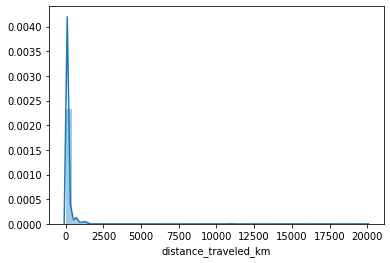

In [42]:
sns.distplot(df['distance_traveled_km'])

In [44]:
df['distance_traveled_km'].quantile(.99)

1265.7037110087654

Some of the observations are too high to make sense, so take out all of the rows where the distance traveled is above the 95th percentile

In [49]:
df = df[df['distance_traveled_km'] <= df['distance_traveled_km'].quantile(.95)]
df['distance_traveled_km'].describe()

count    893465.000000
mean         86.723954
std          63.331436
min           0.000000
25%          37.282462
50%          72.167800
75%         124.030746
max         272.785159
Name: distance_traveled_km, dtype: float64

New distribution after the filtering

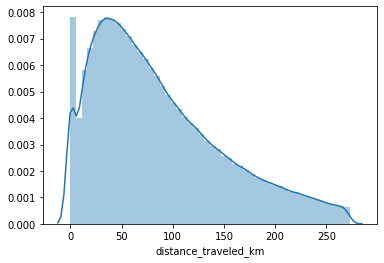

In [51]:
sns.distplot(df['distance_traveled_km'])

Next, I notice that a number of the observations have negative fare_amounts, so I remove them from the df

In [52]:
df = df[df['fare_amount'] > 0]

In [53]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_traveled_km
count,893411.000000,893411.000000,893411.000000,893411.000000,893411.000000,893411.000000,893411.000000
mean,9.171460,-72.440281,39.884995,-72.440925,39.882606,1.681818,86.727982
std,5.939859,10.654217,6.244398,10.700816,6.182784,1.324235,63.330492
min,0.010000,-121.391210,-74.016400,-740.066667,-74.035197,0.000000,0.000000
25%,5.700000,-73.992168,40.735982,-73.991738,40.735081,1.000000,37.287413
50%,7.700000,-73.982162,40.752695,-73.981285,40.753018,1.000000,72.171904
75%,10.900000,-73.969368,40.766469,-73.968139,40.767079,2.000000,124.033448
max,500.000000,40.812887,424.083332,40.815350,47.890090,208.000000,272.785159


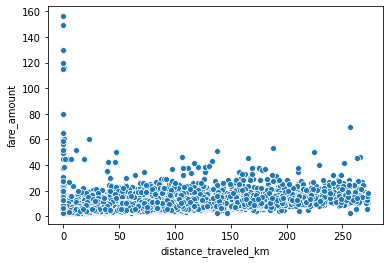

In [55]:
df_sample = df.sample(10000)
sns.scatterplot(x='distance_traveled_km', y='fare_amount', data=df_sample)

Basically what I'm thinking at this point is to first figure out what other values don't make sense and take them out of the data. Then I want to convert the pickup_datetime into a useable timestamp. Finally, I think it could be helpful to build a multiple linear regression using the distance_traveled, passenger_count, and time of day based on the time stamp

In [56]:
df_zero = df[df['distance_traveled_km'] == 0]

In [58]:
len(df_zero)

28478

There are apaprently over 28 k rows where there was no distance traveled, should probably take those out too